Меня зовут Кулешов Семён и в этом ноутбуке я подготовил минимальные исследования для моего Research Proposal для летней школы **Лето с AIRI 2025**.

За основу взята статья из ICML-2023. Explaining Reinforcement Learning with Shapley Values. Daniel Beechey, Thomas M. S. Smith, Özgür Şimşek.

# Воспроизводство кода из статьи

Эксперименты в этом ноутбуке сосредоточены на играх gridworld. Далее в коде конкретная игра из статьи gridworld-C.

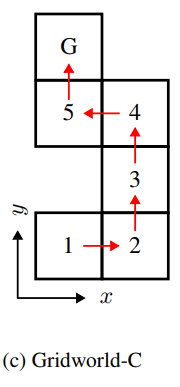

q_agent_1 - там написан стандартный RL-агент

qwc - задана сетка игры

utils - полезные функции

characteristics - содержит функции для подсчета соответствующих характеристических функций $v(.)$

Число прокатываний для оценки мат. ожидания сокращено до $10^5$ для сокращения времени.

In [1]:
import sys
sys.path.insert(0, '../')

from q_agent_1 import Agent
from gwc import Grid
from utils import train, get_state_dist, F_not_i, tqdm_label
from characteristics import Characteristics
import numpy as np

env = Grid()
agent = Agent(env.state_dim, env.num_actions, epsilon=1, gamma=1, alpha=0.2)
states_to_explain = np.array([[0, 0], [1, 0], [1, 1], [1, 2], [0, 2]])

# ------------------------------------------------- TRAIN
train(agent, env, 1e7)

# ------------------------------------------------- GET AGENT'S POLICY
agent.get_policy()

# ------------------------------------------------- APPROXIMATE STATE DIST
state_dist = get_state_dist(agent, env, 1e7)

# ------------------------------------------------- GET AGENT'S VALUE TABLE (for SHAP)
agent.get_value_table()

# ------------------------------------------------- ALL PI_C
pi_Cs = {tuple(C): agent.get_pi_C(C, state_dist, states_to_explain) for C in tqdm_label(F_not_i(np.arange(env.state_dim)), 'Calculating all pi_C')}

# ------------------------------------------------- ALL V_C
v_Cs = {tuple(C): agent.get_v_C(C, state_dist, states_to_explain) for C in tqdm_label(F_not_i(np.arange(env.state_dim)), 'Calculating all v_C')}

# ------------------------------------------------- ALL CHARACTERISTIC VALUES
characteristics = Characteristics(env, states_to_explain)
local_sverl_characteristics = characteristics.local_sverl_C_values(num_rolls=1e5, pi_Cs=pi_Cs, multi_process=True, num_p=5)
global_sverl_characteristics = characteristics.global_sverl_C_values(num_rolls=1e5, pi_Cs=pi_Cs, multi_process=True, num_p=5)
shapley_on_policy_characteristics = characteristics.shapley_on_policy(pi_Cs=pi_Cs, multi_process=True, num_p=5)
shapley_on_value_characteristics = characteristics.shapley_on_value(v_Cs=v_Cs, multi_process=True, num_p=5)

Calculating Characteristics: 100%|██████████| 1/1 [00:00<00:00, 17.13it/s]


Далее функция Шепли, которая считает из хар. функции $v(.)$ непосредственно вектор Шепли. Она также написана в исходной статье.

In [2]:
import math
from collections import defaultdict
from utils import F_not_i

class Shapley:
    """
    Calculates Shapley values given characteristic values.
    """

    def __init__(self, states_to_explain):

        # For Shapley calculations
        self.F_card = len(states_to_explain[0])
        self.F = np.arange(self.F_card)
        self.states = states_to_explain

    def run(self, characteristic_values):
        """
        Calculates all the shapley values for every state and feature.
        """

        shapley_values = defaultdict(lambda: [[] for _ in range(self.F_card)])

        for state in self.states:

            # All characteristic values for a given state.
            C_values = {C: value_table[tuple(state)] for C, value_table in characteristic_values.items()}

            for feature in self.F:

                for C in F_not_i(self.F, feature): # All coalitions without feature

                    # Cardinal of C
                    C_card = len(C)

                    # Add our feature to the current coalition
                    C_with_i = np.append(C, feature).astype(int)
                    C_with_i.sort()

                    # Rolling sum, following formula
                    shapley_values[tuple(state)][feature].append(math.factorial(C_card) * math.factorial(self.F_card - C_card - 1) * (C_values[tuple(C_with_i)] - C_values[tuple(C)]))

                # Final weighting and return
                shapley_values[tuple(state)][feature] = np.sum(shapley_values[tuple(state)][feature], axis=0) / math.factorial(self.F_card)

        return dict(shapley_values)

Сохраняем векторы Шепли в файлы, и выводим их.

In [4]:
import pickle
import os

In [5]:
# ------------------------------------------------- SHAPLEY VALUES
shapley = Shapley(states_to_explain)
for characteristics, filename in zip([local_sverl_characteristics,
                                      global_sverl_characteristics,
                                      shapley_on_policy_characteristics,
                                      shapley_on_value_characteristics], ['original/local', 'original/global', 'original/policy', 'original/value_function']):

    shapley_values = shapley.run(characteristics)
    print(shapley_values)

    folder = os.path.dirname(filename)
    if folder and not os.path.exists(folder):
        os.makedirs(folder)

    with open('{}.pkl'.format(filename), 'wb') as file: pickle.dump(shapley_values, file)

{(np.int64(0), np.int64(0)): [np.float64(4.00118), np.float64(4.00118)], (np.int64(1), np.int64(0)): [np.float64(0.1661299999999999), np.float64(0.6616499999999998)], (np.int64(1), np.int64(1)): [np.float64(0.0028850000000000264), np.float64(0.4979849999999999)], (np.int64(1), np.int64(2)): [np.float64(1.25827), np.float64(2.24978)], (np.int64(0), np.int64(2)): [np.float64(0.32814999999999994), np.float64(0.3342999999999998)]}
{(np.int64(0), np.int64(0)): [np.float64(6.36082), np.float64(10.374010000000002)], (np.int64(1), np.int64(0)): [np.float64(2.3898900000000003), np.float64(6.35016)], (np.int64(1), np.int64(1)): [np.float64(1.377455), np.float64(3.888595)], (np.int64(1), np.int64(2)): [np.float64(1.363275), np.float64(3.408775)], (np.int64(0), np.int64(2)): [np.float64(0.12083500000000003), np.float64(1.1267749999999999)]}
{(np.int64(0), np.int64(0)): [array([-0.33329385,  0.44439175,  0.        , -0.1110979 ]), array([-0.33329375,  0.44439165,  0.        , -0.1110979 ])], (np.in

# Написание собственного подхода подсчета векторов Шепли

Использование глобального вектора Шепли мотивированно в статье. Процитируем ее:

"Например, при автономном вождении пользователь может
захотеть понять, **какие части наблюдений** автономного транспортного средства
**наиболее важны** для производительности вождения,
чтобы сосредоточить ресурсы на улучшении этих частей дорожной
системы. Некоторые характеристики состояния могут существенно
вносить вклад в производительность в определенных состояниях, например, торможение при
наблюдении за человеком или остановка при приближении машины скорой помощи, в то время как дорожная разметка может быть глобально важна,
внося вклад в производительность агента во многих состояниях."


**Вектор Шепли учитывает все подмножества игроков** (в нашем случае — наблюдений) и усредняет вклад каждого наблюдения по всем возможным коалициям **с равными весами**. Однако это не вполне отражает реальную полезность отдельного наблюдения. Нас больше интересует вклад наблюдения в условиях, когда большинство других наблюдений уже доступны. Иначе вопрос сводится к вероятности, с которой конкретное наблюдение может быть зашумлено или недоступно, что требует учета различных весов подмножеств — например, если какие-то наблюдения ломаются чаще других.

Кроме того, **возникает эффект дублирования**: если важная информация (например, пешеход на дороге) отражена в нескольких признаках, вектор Шепли присвоит высокую важность всем этим признакам. Но с практической точки зрения достаточно иметь 1–2 надежных признака, так как остальные не дают новой информации.

Я хочу продемонстрировать эту проблему на новой сетке gridworld-D, сравнив стандартный вектор Шепли из статьи и мой модифицированный подход. **В моем подходе**, помимо характерической функции, **вектор Шепли учитывает распределение вероятностей для подмножеств игроков**. Для простоты можно задать модель, где **каждый игрок $i$ включается независимо с вероятностью $p_i$**, и вклад каждого игрока вычисляется как математическое ожидание его вклада с учетом этого распределения.

Формула: $\phi_i = \mathbb{E}_{X_i} \left[ v(X_i \cup \{i\}) - v(X_i) \right]$

где $X_i$ - случайное подмножество игроков без $i$-ого.

Реализуем ее в коде.

Будем считать, что $P(X_k) = \prod_{i \in X_k} p_i \times \prod_{j \in F_k \setminus X_k} (1 - p_j)$

где $F_k$ - все игроки (наблюдения) кроме $k$-ого.

P.S. Строго говоря вектор в моем подходе не является вектором Шепли некоторой кооперативной игры, поскольку сумма вкладов каждого игрока не будет равна суммарному выигрышу. Это необходимо допустить для избегания эффекта дублирования.

In [6]:
import numpy as np
from collections import defaultdict
from utils import F_not_i

class ExpectedShapley:
    """
    Computes Shapley values as an expectation over random feature failures,
    using independent failure probabilities (1 - p_vector[i]) for each feature.
    """

    def __init__(self, states_to_explain, p_vector):
        self.F_card = len(states_to_explain[0])  # Number of features
        self.F = np.arange(self.F_card)          # Feature indices
        self.states = states_to_explain          # States to explain
        self.p_vector = p_vector                 # Probabilities of keeping each feature (not failing)

    def run(self, characteristic_values):
        """
        Calculates Shapley values for each state and feature under random failures.
        """

        shapley_values = defaultdict(lambda: np.zeros(self.F_card))

        for state in self.states:
            # Extract characteristic values for this state
            C_values = {C: value_table[tuple(state)] for C, value_table in characteristic_values.items()}

            for i in self.F:
                phi_i = 0  # Initialize expected contribution for feature i

                # Loop over all coalitions not containing feature i
                for C in F_not_i(self.F, i):
                    C_set = set(C)
                    C_with_i = tuple(sorted(C_set | {i}))

                    # Compute probability of this coalition C occurring
                    p_C = 1.0
                    for j in self.F:
                        if j in C_set:
                            p_C *= self.p_vector[j]
                        elif j != i:  # feature i is not in C by definition
                            p_C *= (1 - self.p_vector[j])

                    # Compute marginal contribution of feature i in context of C
                    marginal_contrib = C_values[C_with_i] - C_values[tuple(C)]

                    # Weighted contribution
                    phi_i += p_C * marginal_contrib

                shapley_values[tuple(state)][i] = phi_i

        return dict(shapley_values)


Посчитаем значения вектора Шепли в модифицированном подходе для вектора вероятностей $(0.9, 0.9)$, что соответствует тому, что каждый из признаков часто находится в подмножестве оставшихся признаков.

In [10]:
p_vector = [0.9, 0.9]
expShapley = ExpectedShapley(states_to_explain, p_vector)
for characteristics, filename in zip([local_sverl_characteristics,
                                      global_sverl_characteristics], ['modified/local-90', 'modified/global-90']):

    expShapley_values = expShapley.run(characteristics)
    print(expShapley_values)

    folder = os.path.dirname(filename)
    if folder and not os.path.exists(folder):
        os.makedirs(folder)

    with open('{}.pkl'.format(filename), 'wb') as file: pickle.dump(expShapley_values, file)

{(np.int64(0), np.int64(0)): array([2.399956, 2.399956]), (np.int64(1), np.int64(0)): array([0.43433, 0.92985]), (np.int64(1), np.int64(1)): array([0.000577, 0.495677]), (np.int64(1), np.int64(2)): array([1.055822, 2.047332]), (np.int64(0), np.int64(2)): array([0.867638, 0.873788])}
{(np.int64(0), np.int64(0)): array([4.873156, 8.886346]), (np.int64(1), np.int64(0)): array([2.478946, 6.439216]), (np.int64(1), np.int64(1)): array([1.869723, 4.380863]), (np.int64(1), np.int64(2)): array([1.865135, 3.910635]), (np.int64(0), np.int64(2)): array([0.818863, 1.824803])}


In [11]:
filename = 'modified/global-90.pkl'

with open(filename, 'rb') as file:
    local_data = pickle.load(file)

vectors = list(local_data.values())

vectors = np.array(vectors)
print(vectors)

mean_first_coord = np.mean(vectors[:, 0])
mean_second_coord = np.mean(vectors[:, 1])

print(f"Среднее по x: {mean_first_coord}")
print(f"Среднее по y: {mean_second_coord}")

[[4.873156 8.886346]
 [2.478946 6.439216]
 [1.869723 4.380863]
 [1.865135 3.910635]
 [0.818863 1.824803]]
Среднее по x: 2.3811646000000004
Среднее по y: 5.0883726000000005


In [12]:
filename = 'original/global.pkl'

with open(filename, 'rb') as file:
    local_data = pickle.load(file)

vectors = list(local_data.values())

vectors = np.array(vectors)
print(vectors)

mean_first_coord = np.mean(vectors[:, 0])
mean_second_coord = np.mean(vectors[:, 1])

print(f"Среднее по x: {mean_first_coord}")
print(f"Среднее по y: {mean_second_coord}")

[[ 6.36082  10.37401 ]
 [ 2.38989   6.35016 ]
 [ 1.377455  3.888595]
 [ 1.363275  3.408775]
 [ 0.120835  1.126775]]
Среднее по x: 2.322455
Среднее по y: 5.029662999999999


Как мы видим оригинальный и модифицированные подходы с точки зрения глобального вектора Шепли несильно различаются в gridworld-c. Эффекта дублирования в этой задаче нет, поэтому это говорит о разумности моего подхода.

# Превосходство моего подхода в gridworld-d

Для демонстрации эффекта поменяем сетку. Возьмем за основу gridworld-c, но добавим третью координату $z$. Она будет всегда равна $y$. При этом для сохранения логики игры варианты ходов меняться не будут, их останется четыре, как и было. Значение $z$ будет меняться вслед за $y$, по сути это вторая версия $y$ (дублирующая).

Новую игру назовем gridworld-d.

Напишем новую сетку.

In [14]:
import numpy as np

class GridExp:
    """
    2 x 4 grid world where top left square is a goal.
    Grid has a border around the sides.
    (0, 1) and (1, 3) are impassible blocks.
    Reward is -1 each step and +10 for reaching the goal.
    Initial position is randomly sampled from bottom two squares.
    Now, state is (x, y, y) where third coordinate duplicates y.
    """

    def __init__(self):
        # 4 height and 2 width
        H = 4
        W = 2
        self.grid = np.zeros((H, W))

        self.num_actions = 4
        self.state_dim = 3  # Now 3 dimensions: (x, y, duplicate_y)

        self.start = np.array([[0, 0, 0], [1, 0, 0]])  # Added duplicate y=0

        self.trans = np.zeros((W, H-1, 4, 4), dtype=int)  # x, y, action -> (new_x, new_y, reward, done)

        self.action_dict = {0: [0, 1],  # Right
                            1: [1, 0],  # Down
                            2: [0, -1], # Left
                            3: [-1, 0]} # Up

        for y, row in enumerate(self.grid[:-1]):
            for x, _ in enumerate(row):

                state = np.array([x, y])

                for k in range(4):
                    reward_done = np.array([-1, 0])

                    new_state = state + self.action_dict[k]

                    # Check if hitting wall or invalid move
                    if not ((new_state[1] in np.arange(H)) and (new_state[0] in np.arange(W))) or (new_state == [[0, 1], [1, 3]]).all(axis=1).any():
                        new_state = state
                    elif new_state[1] == H-1:
                        reward_done += [10, 1]

                    # Update transition table
                    self.trans[x, y, k] = np.append(new_state, reward_done)

    def reset(self, start_state=None):
        """
        Randomly places the agent in one of the bottom two squares,
        or sets environment to the given state.
        """

        if start_state is None:
            base_pos = self.start[np.random.choice(2)]
        else:
            base_pos = np.array(start_state)

        # Always ensure third coordinate duplicates y
        self.pos = np.array([base_pos[0], base_pos[1], base_pos[1]])

        return self.pos.copy(), None

    def step(self, action):
        """
        Takes a step in the environment with state (x, y, duplicate_y).
        """

        new_state_reward_done = self.trans[self.pos[0], self.pos[1], action]
        new_x, new_y = new_state_reward_done[0], new_state_reward_done[1]

        # Update position: (new_x, new_y, new_y)
        self.pos = np.array([new_x, new_y, new_y])

        return self.pos.copy(), new_state_reward_done[2], new_state_reward_done[3], False, False


Обучим агента и посчитаем все необходимые характеристические функции.

In [15]:
env = GridExp()
agent = Agent(env.state_dim, env.num_actions, epsilon=1, gamma=1, alpha=0.2)
states_to_explain = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 1], [1, 2, 2], [0, 2, 2]])

# ------------------------------------------------- TRAIN
train(agent, env, 1e7)

# ------------------------------------------------- GET AGENT'S POLICY
agent.get_policy()

# ------------------------------------------------- APPROXIMATE STATE DIST
state_dist = get_state_dist(agent, env, 1e7)

# ------------------------------------------------- GET AGENT'S VALUE TABLE (for SHAP)
agent.get_value_table()

# ------------------------------------------------- ALL PI_C
pi_Cs = {tuple(C): agent.get_pi_C(C, state_dist, states_to_explain) for C in tqdm_label(F_not_i(np.arange(env.state_dim)), 'Calculating all pi_C')}

# ------------------------------------------------- ALL V_C
v_Cs = {tuple(C): agent.get_v_C(C, state_dist, states_to_explain) for C in tqdm_label(F_not_i(np.arange(env.state_dim)), 'Calculating all v_C')}

# ------------------------------------------------- ALL CHARACTERISTIC VALUES
characteristics = Characteristics(env, states_to_explain)
local_sverl_characteristics = characteristics.local_sverl_C_values(num_rolls=1e5, pi_Cs=pi_Cs, multi_process=True, num_p=5)
global_sverl_characteristics = characteristics.global_sverl_C_values(num_rolls=1e5, pi_Cs=pi_Cs, multi_process=True, num_p=5)

Calculating Characteristics: 100%|██████████| 2/2 [12:19<00:00, 369.95s/it]


Посчитаем вектора Шепли в старом подходе.

In [17]:
# ------------------------------------------------- SHAPLEY VALUES
shapley = Shapley(states_to_explain)
for characteristics, filename in zip([local_sverl_characteristics,
                                      global_sverl_characteristics], ['gridworld-d/local-origin', 'gridworld-d/global-origin']):

    shapley_values = shapley.run(characteristics)
    print(shapley_values)
    folder = os.path.dirname(filename)
    if folder and not os.path.exists(folder):
        os.makedirs(folder)

    with open('{}.pkl'.format(filename), 'wb') as file: pickle.dump(shapley_values, file)

{(np.int64(0), np.int64(0), np.int64(0)): [np.float64(3.3335033333333333), np.float64(2.3324683333333334), np.float64(2.3324683333333334)], (np.int64(1), np.int64(0), np.int64(0)): [np.float64(0.2766433333333331), np.float64(0.2756733333333334), np.float64(0.2756733333333334)], (np.int64(1), np.int64(1), np.int64(1)): [np.float64(-0.0012266666666667092), np.float64(0.2477733333333334), np.float64(0.2477733333333334)], (np.int64(1), np.int64(2), np.int64(2)): [np.float64(1.16143), np.float64(1.16151), np.float64(1.16151)], (np.int64(0), np.int64(2), np.int64(2)): [np.float64(0.5554566666666668), np.float64(0.05677666666666662), np.float64(0.05677666666666662)]}
{(np.int64(0), np.int64(0), np.int64(0)): [np.float64(5.768156666666667), np.float64(5.520416666666667), np.float64(5.520416666666667)], (np.int64(1), np.int64(0), np.int64(0)): [np.float64(2.42756), np.float64(3.155765), np.float64(3.155765)], (np.int64(1), np.int64(1), np.int64(1)): [np.float64(1.5872466666666663), np.float64(1

Посчитаем вектора Шепли в модифицированном подходе для вектора вероятностей (0.9, 0.9, 0.9).

In [18]:
p_vector = [0.9, 0.9, 0.9]
expShapley = ExpectedShapley(states_to_explain, p_vector)
for characteristics, filename in zip([local_sverl_characteristics,
                                      global_sverl_characteristics], ['gridworld-d/local-modified-90', 'gridworld-d/global-modified-90']):

    expShapley_values = expShapley.run(characteristics)
    print(expShapley_values)
    folder = os.path.dirname(filename)
    if folder and not os.path.exists(folder):
        os.makedirs(folder)

    with open('{}.pkl'.format(filename), 'wb') as file: pickle.dump(expShapley_values, file)

{(np.int64(0), np.int64(0), np.int64(0)): array([2.042013, 0.24015 , 0.24015 ]), (np.int64(1), np.int64(0), np.int64(0)): array([0.4975867, 0.0938567, 0.0938567]), (np.int64(1), np.int64(1), np.int64(1)): array([-3.68000e-05,  4.97632e-02,  4.97632e-02]), (np.int64(1), np.int64(2), np.int64(2)): array([1.00623 , 0.205102, 0.205102]), (np.int64(0), np.int64(2), np.int64(2)): array([0.9813869, 0.0860029, 0.0860029])}
{(np.int64(0), np.int64(0), np.int64(0)): array([4.5316621, 0.8873781, 0.8873781]), (np.int64(1), np.int64(0), np.int64(0)): array([2.5104077, 0.6456727, 0.6456727]), (np.int64(1), np.int64(1), np.int64(1)): array([1.9887426, 0.4370356, 0.4370356]), (np.int64(1), np.int64(2), np.int64(2)): array([1.9869529, 0.3891179, 0.3891179]), (np.int64(0), np.int64(2), np.int64(2)): array([0.9802503, 0.1837593, 0.1837593])}


Посчитаем вектора Шепли в модифицированном подходе для вектора вероятностей (1, 1, 1).

In [19]:
p_vector = [1, 1, 1]
expShapley = ExpectedShapley(states_to_explain, p_vector)
for characteristics, filename in zip([local_sverl_characteristics,
                                      global_sverl_characteristics], ['gridworld-d/local-modified-100', 'gridworld-d/global-modified-100']):

    expShapley_values = expShapley.run(characteristics)
    print(expShapley_values)
    folder = os.path.dirname(filename)
    if folder and not os.path.exists(folder):
        os.makedirs(folder)
    with open('{}.pkl'.format(filename), 'wb') as file: pickle.dump(expShapley_values, file)

{(np.int64(0), np.int64(0), np.int64(0)): array([2.00207, 0.     , 0.     ]), (np.int64(1), np.int64(0), np.int64(0)): array([0.50442, 0.     , 0.     ]), (np.int64(1), np.int64(1), np.int64(1)): array([0., 0., 0.]), (np.int64(1), np.int64(2), np.int64(2)): array([1.00143, 0.     , 0.     ]), (np.int64(0), np.int64(2), np.int64(2)): array([0.99456, 0.     , 0.     ])}
{(np.int64(0), np.int64(0), np.int64(0)): array([4.49342, 0.     , 0.     ]), (np.int64(1), np.int64(0), np.int64(0)): array([2.51297, 0.     , 0.     ]), (np.int64(1), np.int64(1), np.int64(1)): array([2.00116, 0.     , 0.     ]), (np.int64(1), np.int64(2), np.int64(2)): array([1.99953, 0.     , 0.     ]), (np.int64(0), np.int64(2), np.int64(2)): array([0.99806, 0.     , 0.     ])}


Посчитаем вектора Шепли в модифицированном подходе для вектора вероятностей (0.5, 0.5, 0.5).

In [20]:
p_vector = [0.5, 0.5, 0.5]
expShapley = ExpectedShapley(states_to_explain, p_vector)
for characteristics, filename in zip([local_sverl_characteristics,
                                      global_sverl_characteristics], ['gridworld-d/local-modified-50', 'gridworld-d/global-modified-50']):

    expShapley_values = expShapley.run(characteristics)
    print(expShapley_values)
    folder = os.path.dirname(filename)
    if folder and not os.path.exists(folder):
        os.makedirs(folder)

    with open('{}.pkl'.format(filename), 'wb') as file: pickle.dump(expShapley_values, file)

{(np.int64(0), np.int64(0), np.int64(0)): array([3.000645, 1.99961 , 1.99961 ]), (np.int64(1), np.int64(0), np.int64(0)): array([0.3335875, 0.3326175, 0.3326175]), (np.int64(1), np.int64(1), np.int64(1)): array([-0.00092,  0.24808,  0.24808]), (np.int64(1), np.int64(2), np.int64(2)): array([1.12143, 1.12151, 1.12151]), (np.int64(0), np.int64(2), np.int64(2)): array([0.6652325, 0.1665525, 0.1665525])}
{(np.int64(0), np.int64(0), np.int64(0)): array([5.4494725, 5.2017325, 5.2017325]), (np.int64(1), np.int64(0), np.int64(0)): array([2.4489125, 3.1771175, 3.1771175]), (np.int64(1), np.int64(1), np.int64(1)): array([1.690725, 1.93683 , 1.93683 ]), (np.int64(1), np.int64(2), np.int64(2)): array([1.6851025, 1.6940475, 1.6940475]), (np.int64(0), np.int64(2), np.int64(2)): array([0.5528175, 0.5626025, 0.5626025])}


Посчитаем вектора Шепли в модифицированном подходе для вектора вероятностей (0, 0, 0).

In [21]:
p_vector = [0, 0, 0]
expShapley = ExpectedShapley(states_to_explain, p_vector)
for characteristics, filename in zip([local_sverl_characteristics,
                                      global_sverl_characteristics], ['gridworld-d/local-modified-0', 'gridworld-d/global-modified-0']):

    expShapley_values = expShapley.run(characteristics)
    print(expShapley_values)
    folder = os.path.dirname(filename)
    if folder and not os.path.exists(folder):
        os.makedirs(folder)

    with open('{}.pkl'.format(filename), 'wb') as file: pickle.dump(expShapley_values, file)

{(np.int64(0), np.int64(0), np.int64(0)): array([5.99637, 5.99637, 5.99637]), (np.int64(1), np.int64(0), np.int64(0)): array([-0.17891,  0.32357,  0.32357]), (np.int64(1), np.int64(1), np.int64(1)): array([-0.00368,  0.49432,  0.49432]), (np.int64(1), np.int64(2), np.int64(2)): array([1.48143, 2.48302, 2.48302]), (np.int64(0), np.int64(2), np.int64(2)): array([-0.32275, -0.32555, -0.32555])}
{(np.int64(0), np.int64(0), np.int64(0)): array([ 8.31763, 12.31557, 12.31557]), (np.int64(1), np.int64(0), np.int64(0)): array([2.25674, 6.22612, 6.22612]), (np.int64(1), np.int64(1), np.int64(1)): array([0.75942, 3.25279, 3.25279]), (np.int64(1), np.int64(2), np.int64(2)): array([0.74182, 2.75924, 2.75924]), (np.int64(0), np.int64(2), np.int64(2)): array([-0.78291,  0.23472,  0.23472])}


Теперь сравним оригинальный глобальный вектор Шепли и модифицированный.

In [22]:
filename = 'gridworld-d/global-origin.pkl'

with open(filename, 'rb') as file:
    local_data = pickle.load(file)

vectors = list(local_data.values())

vectors = np.array(vectors)
print(vectors)

mean_first_coord = np.mean(vectors[:, 0])
mean_second_coord = np.mean(vectors[:, 1])
mean_third_coord = np.mean(vectors[:, 2])

# Выводим результат
print(f"Среднее по x: {mean_first_coord}")
print(f"Среднее по y: {mean_second_coord}")
print(f"Среднее по z: {mean_third_coord}")

[[5.76815667 5.52041667 5.52041667]
 [2.42756    3.155765   3.155765  ]
 [1.58724667 1.83335167 1.83335167]
 [1.58029333 1.58923833 1.58923833]
 [0.40440333 0.41418833 0.41418833]]
Среднее по x: 2.3535320000000004
Среднее по y: 2.5025920000000004
Среднее по z: 2.5025920000000004


In [23]:
filename = 'gridworld-d/global-modified-90.pkl'

with open(filename, 'rb') as file:
    local_data = pickle.load(file)

vectors = list(local_data.values())

vectors = np.array(vectors)
print(vectors)

mean_first_coord = np.mean(vectors[:, 0])
mean_second_coord = np.mean(vectors[:, 1])
mean_third_coord = np.mean(vectors[:, 2])

# Выводим результат
print(f"Среднее по x: {mean_first_coord}")
print(f"Среднее по y: {mean_second_coord}")
print(f"Среднее по z: {mean_third_coord}")

[[4.5316621 0.8873781 0.8873781]
 [2.5104077 0.6456727 0.6456727]
 [1.9887426 0.4370356 0.4370356]
 [1.9869529 0.3891179 0.3891179]
 [0.9802503 0.1837593 0.1837593]]
Среднее по x: 2.39960312
Среднее по y: 0.50859272
Среднее по z: 0.50859272


Как мы видим в моем подходе значения у второй и третьей координаты значительно меньше, чем в оригинальном подходе.

Это здраво отображает логику - если вероятность поломки признаков маленькая, то наиболее полезной будет та, для которой нет замены.

Отметим, что в оригинальном подходе вектор Шепли лишь поделил полезность от изначального $y$ между $y, z$, проигнориров эффект замещения двух координат.

In [24]:
import os
from google.colab import files

folders = ['original', 'modified', 'gridworld-d']

for folder in folders:
    if os.path.exists(folder):
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            if os.path.isfile(filepath):
                print(f"Скачиваем {filepath}...")
                files.download(filepath)

Скачиваем original/policy.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем original/global.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем original/value_function.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем original/local.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем modified/local-90.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем modified/global-90.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем gridworld-d/local-modified-100.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем gridworld-d/local-modified-90.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем gridworld-d/global-modified-50.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем gridworld-d/local-modified-0.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем gridworld-d/global-origin.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем gridworld-d/local-modified-50.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем gridworld-d/global-modified-100.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем gridworld-d/global-modified-90.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем gridworld-d/local-origin.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Скачиваем gridworld-d/global-modified-0.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>